# Merging volumentric ROI measures and freesurfer surface measures.
- Cortical thickness/volume/aseg/wmparc data generated by "../tab_data/freesurfer_stats2table.sh" from fMRIPrep_20.2.0 freesurfer_6.0.1
- Cerebellar segmetations in both SUIT34 and MDTB10 spaces.
- Uses participants data (../tab_data/MNI_subjects.list) as target to join, all NaN values droped;
## Cohorts
- MNI ET/NC (sub-0073(# only left brain NC), sub-0064(# super large head NC with freesurfer problems) have been removed 
## Parcellations
- Distreux
- DKT
## Results
- Distreux: ../tab_data/'freesurfer-preped_MNI.csv'
- DKT:      ../tab_data/ADNI-PPMI_DKT-cere_preped.csv (NOT READY)

In [1]:
## Preprocessing of MNI dataset freesurfer outputs
## Merging all PD/ET/NC freesurfer outputs into one table. /root/tab_data/all_freesurfer_out.csv
from pathlib import Path
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
data_dir = Path("/codes/tab_data")
sub_list_file = data_dir/'MNI_subjects.list'
sub_list_all = pd.read_csv(sub_list_file, sep='\t', header=0, index_col=0)

# reading freesurfer results
FS_DIR   = data_dir/'freesurfer_output_20.2.0'
GROUPS   = ['ET','NC']
n_groups = len(GROUPS);
group_data={};

#get subject list for ET and NC
sub_list=[sub_list_all[sub_list_all['diagnosis']==x] for x in GROUPS];
# output file
#res_file = data_dir/'MNI_Des-cere_preped.csv'
res_file = [data_dir/'MNI_Des-cere_preped.csv', data_dir/'MNI_DKT-cere_preped.csv']

# combined_res_file = [data_dir/'freesurfer_out_preped.csv']
# file name dict
files_2_read={'seg': ['aseg_stats.txt', 'wmparc_stats.txt'],
              'Destrieux': {'ct': '.a2009s.thickness.txt','area':'.a2009s.area.txt', 'volume':'.a2009s.volume.txt', 'meancurv':'.a2009s.meancurv.txt'},
              'DKT': {'ct': '.DKTatlas.thickness.txt','area':'.DKTatlas.area.txt', 'volume':'.DKTatlas.volume.txt', 'meancurv':'.DKTatlas.meancurv.txt'}}

for i_group in range(n_groups):
    """
    Loop to gather all the freesurfer outputs for ET/PD/NC MNI group.
    Output: all_data (dataframe).
    """
    print('Reading ' , GROUPS[i_group], ' freesurfer stats data...')
    raw_data_path = FS_DIR/GROUPS[i_group]
    
    # preparing files
    subcortical_file = raw_data_path / (files_2_read['seg'][0]); wm_file = raw_data_path / (files_2_read['seg'][1]);
    # Des parcellation
    lh_Des_ct_file = raw_data_path / ('lh'+files_2_read['Destrieux']['ct']);  rh_Des_ct_file = raw_data_path /  ('rh'+files_2_read['Destrieux']['ct']);
    lh_Des_vol_file = raw_data_path / ('lh'+files_2_read['Destrieux']['volume']); rh_Des_vol_file = raw_data_path / ('rh'+files_2_read['Destrieux']['volume']);
    lh_Des_area_file = raw_data_path / ('lh'+files_2_read['Destrieux']['area']); rh_Des_area_file = raw_data_path / ('rh'+files_2_read['Destrieux']['area']);
    lh_Des_meancurv_file = raw_data_path / ('lh'+files_2_read['Destrieux']['meancurv']); rh_Des_meancurv_file = raw_data_path / ('rh'+files_2_read['Destrieux']['meancurv']);
    # DKT parcellation
    lh_DKT_area_file = raw_data_path / ('lh'+files_2_read['DKT']['area']);       rh_DKT_area_file = raw_data_path / ('rh'+files_2_read['DKT']['area']);
    lh_DKT_ct_file = raw_data_path / ('lh'+files_2_read['DKT']['ct']);        rh_DKT_ct_file = raw_data_path /  ('rh'+files_2_read['DKT']['ct']);
    lh_DKT_vol_file = raw_data_path / ('lh'+files_2_read['DKT']['volume']);       rh_DKT_vol_file = raw_data_path / ('rh'+files_2_read['DKT']['volume']);
    lh_DKT_meancurv_file = raw_data_path / ('lh'+files_2_read['DKT']['meancurv']);       rh_DKT_meancurv_file = raw_data_path / ('rh'+files_2_read['DKT']['meancurv']);
    ## drop_list
    aseg_drop = ["EstimatedTotalIntraCranialVol"]; 
    wm_drop = ["MaskVol", "EstimatedTotalIntraCranialVol", "CerebralWhiteMatterVol", "rhCerebralWhiteMatterVol", "lhCerebralWhiteMatterVol"];
    parc_drop = ["BrainSegVolNotVent", "eTIV"]; 
    sub_list[i_group].loc[:, 'site']='mni_001'
    sub_list[i_group].loc[:, 'group'] = sub_list[i_group].loc[:, 'diagnosis'];
    # read files
    subcortical_tab = pd.read_csv(subcortical_file, sep='\t', header=0, index_col=0); 
    subcortical_tab['eTIV']=subcortical_tab['EstimatedTotalIntraCranialVol']
    subcortical_tab.drop(aseg_drop, axis=1, inplace=True);
    # site
    res = sub_list[i_group].join(subcortical_tab, how='left');
    wm_tab = pd.read_csv(wm_file, sep='\t', header=0, index_col=0); wm_tab.drop(wm_drop, axis=1, inplace=True);
    res1   = res.join(wm_tab, how='left');
    # read Des/DKT parcelation data
    lh_Des_ct_tab  = pd.read_csv(lh_Des_ct_file,  sep='\t', header=0, index_col=0);       lh_Des_ct_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_ct_tab  = pd.read_csv(rh_Des_ct_file,  sep='\t', header=0, index_col=0);       rh_Des_ct_tab.drop(parc_drop, axis=1, inplace=True);
    lh_Des_vol_tab = pd.read_csv(lh_Des_vol_file, sep='\t', header=0, index_col=0);       lh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_vol_tab = pd.read_csv(rh_Des_vol_file, sep='\t', header=0, index_col=0);       rh_Des_vol_tab.drop(parc_drop, axis=1, inplace=True);
    lh_Des_area_tab = pd.read_csv(lh_Des_area_file, sep='\t', header=0, index_col=0);     lh_Des_area_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_area_tab = pd.read_csv(rh_Des_area_file, sep='\t', header=0, index_col=0);     rh_Des_area_tab.drop(parc_drop, axis=1, inplace=True);
    lh_Des_curv_tab = pd.read_csv(lh_Des_meancurv_file, sep='\t', header=0, index_col=0); lh_Des_curv_tab.drop(parc_drop, axis=1, inplace=True);
    rh_Des_curv_tab = pd.read_csv(rh_Des_meancurv_file, sep='\t', header=0, index_col=0); rh_Des_curv_tab.drop(parc_drop, axis=1, inplace=True);
    # DKT atlas
    lh_DKT_ct_tab  = pd.read_csv(lh_DKT_ct_file,  sep='\t', header=0, index_col=0);       lh_DKT_ct_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_ct_tab  = pd.read_csv(rh_DKT_ct_file,  sep='\t', header=0, index_col=0);       rh_DKT_ct_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_vol_tab = pd.read_csv(lh_DKT_vol_file, sep='\t', header=0, index_col=0);       lh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_vol_tab = pd.read_csv(rh_DKT_vol_file, sep='\t', header=0, index_col=0);       rh_DKT_vol_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_area_tab = pd.read_csv(lh_DKT_area_file, sep='\t', header=0, index_col=0);     lh_DKT_area_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_area_tab = pd.read_csv(rh_DKT_area_file, sep='\t', header=0, index_col=0);     rh_DKT_area_tab.drop(parc_drop, axis=1, inplace=True);
    lh_DKT_curv_tab = pd.read_csv(lh_DKT_meancurv_file, sep='\t', header=0, index_col=0); lh_DKT_curv_tab.drop(parc_drop, axis=1, inplace=True);
    rh_DKT_curv_tab = pd.read_csv(rh_DKT_meancurv_file, sep='\t', header=0, index_col=0); rh_DKT_curv_tab.drop(parc_drop, axis=1, inplace=True);
    # merge Des/DKT parcelation data
    seg_Des_tab=       res1.join(lh_Des_ct_tab, how='left');  seg_Des_tab=seg_Des_tab.join(rh_Des_ct_tab, how='left'); 
    seg_Des_tab=seg_Des_tab.join(lh_Des_vol_tab,how='left');  seg_Des_tab=seg_Des_tab.join(rh_Des_vol_tab,how='left'); 
    seg_Des_tab=seg_Des_tab.join(lh_Des_area_tab,how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_area_tab,how='left');
    seg_Des_tab=seg_Des_tab.join(lh_Des_curv_tab,how='left'); seg_Des_tab=seg_Des_tab.join(rh_Des_curv_tab,how='left');
    
    seg_DKT_tab=res1.join(lh_DKT_ct_tab, how='left');         seg_DKT_tab=seg_DKT_tab.join(rh_DKT_ct_tab, how='left'); 
    seg_DKT_tab=seg_DKT_tab.join(lh_DKT_vol_tab,how='left');  seg_DKT_tab=seg_DKT_tab.join(rh_DKT_vol_tab,how='left'); 
    seg_DKT_tab=seg_DKT_tab.join(lh_DKT_area_tab,how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_DKT_area_tab,how='left'); 
    seg_DKT_tab=seg_DKT_tab.join(lh_Des_curv_tab,how='left'); seg_DKT_tab=seg_DKT_tab.join(rh_Des_curv_tab,how='left'); 
    # return data
    group_data[GROUPS[i_group]]={'Des': seg_Des_tab, 'DKT':seg_DKT_tab}
all_data = {'Des': pd.concat([group_data['ET']['Des'], group_data['NC']['Des']]), 'DKT': pd.concat([group_data['ET']['DKT'], group_data['NC']['DKT']])}
for k, v in all_data.items():
    v.index   = [x.replace('-','_') for x in v.index]
    v.columns = [x.replace('-','_') for x in v.columns]
for x in GROUPS:
    print(x , len(group_data[x]['Des']))
    
#all_data = pd.concat([group_data['PD'], group_data['ET'], group_data['NC']])
#all_data['group']=all_data['diagnosis']; all_data=all_data.drop(columns=['diagnosis']);
#all_data['site']='mni_001'
#for x in GROUPS:
#    print(x , len(all_data[all_data["group"]==x]))

Reading  ET  freesurfer stats data...


/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1597: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[key] = value
/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1720: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._setitem_single_column(loc, value, pi)
/usr/local/miniconda/lib/python3.8/site-packages/pandas/core/indexing.py:1676: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexe

Reading  NC  freesurfer stats data...
ET 38
NC 32


In [2]:
##Fixing all the format problems: 1. All '-' are replaced by '_'; 
seg_col =[x.replace('-','_') for x in subcortical_tab.columns];
wm_col  =[x.replace('-','_') for x in wm_tab.columns]
lh_des_ct_col=[x.replace('-','_') for x in lh_Des_ct_tab.columns]; rh_des_ct_col=[x.replace('-','_') for x in rh_Des_ct_tab.columns];
lh_dkt_ct_col=[x.replace('-','_') for x in lh_DKT_ct_tab.columns]; rh_dkt_ct_col=[x.replace('-','_') for x in rh_DKT_ct_tab.columns];
lh_des_vol_col=[x.replace('-','_') for x in lh_Des_vol_tab.columns]; rh_des_vol_col=[x.replace('-','_') for x in rh_Des_vol_tab.columns];
lh_dkt_vol_col=[x.replace('-','_') for x in lh_DKT_vol_tab.columns]; rh_dkt_vol_col=[x.replace('-','_') for x in rh_DKT_vol_tab.columns];
rh_dkt_vol_col.pop()

In [3]:
## adding cerebellar measures from SUIT software in both SUIT space and MDTB space.
#SUIT space
suit_res_file = data_dir/'res_MNI_SUIT34.csv'

suit_label_file  = data_dir/'atlas'/'Lobules-SUIT.nii.lut'
suit_label_df = pd.read_csv(suit_label_file, sep=' ', header=None, index_col=None); 

suit_res_df = pd.read_csv(suit_res_file, sep=',', header=None, index_col=None)
suit_res_df.index=all_data['DKT'].index;
suit_res_df.columns=suit_label_df.iloc[:,7]; suit_res_df['suit_total']=suit_res_df.sum(axis=1)

#MDTB space
MDTB_res_file = data_dir/'res_MNI_MDTB10.csv'
MDTB_res_df = pd.read_csv(MDTB_res_file, sep=',', header=None, index_col=None)
MDTB_res_df.index=all_data['DKT'].index;
MDTB_res_df.columns=['MDTB_'+str(x+1) for x in range(10)]; MDTB_res_df['MDTB_total']=MDTB_res_df.sum(axis=1)

cereb_merge=suit_res_df.join(MDTB_res_df, how='left');
all_data['Des'] = all_data['Des'].join(cereb_merge, how='left'); #all_data['Des']=all_data['Des'].dropna();
all_data['DKT'] = all_data['DKT'].join(cereb_merge, how='left'); #all_data['DKT']=all_data['DKT'].dropna();
suit_col =[x for x in suit_res_df.columns]; mdtb_col =[x for x in MDTB_res_df.columns];
# dropNA, remove all subjects with any NaN, sub_021S0984 for no freesurfer results.
all_data['Des']=all_data['Des'].dropna(axis=1);
all_data['DKT']=all_data['DKT'].dropna(axis=1);

In [4]:
SUIT_labels =['Left_I_IV','Right_I_IV','Left_V','Right_V','Left_VI','Vermis_VI','Right_VI','Left_CrusI','Vermis_CrusI','Right_CrusI','Left_CrusII','Vermis_CrusII','Right_CrusII','Left_VIIb','Vermis_VIIb','Right_VIIb','Left_VIIIa','Vermis_VIIIa','Right_VIIIa','Left_VIIIb','Vermis_VIIIb','Right_VIIIb','Left_IX','Vermis_IX','Right_IX','Left_X','Vermis_X','Right_X','Left_Dentate','Right_Dentate','Left_Interposed','Right_Interposed','Left_Fastigial','Right_Fastigial'];
SUIT_labels = [ x.replace('-','_') for x in SUIT_labels]
SUIT_l_labels =['Left_I_IV',  'Left_V', 'Left_VI', 'Left_CrusI', 'Left_CrusII', 'Left_VIIb', 'Left_VIIIa', 'Left_VIIIb', 'Left_IX', 'Left_X', 'Left_Dentate', 'Left_Interposed', 'Left_Fastigial'];
SUIT_r_labels =['Right_I_IV','Right_V','Right_VI','Right_CrusI','Right_CrusII','Right_VIIb','Right_VIIIa','Right_VIIIb','Right_IX','Right_X','Right_Dentate','Right_Interposed','Right_Fastigial'];
SUIT_v_labels =['Vermis_VI', 'Vermis_CrusI', 'Vermis_CrusII', 'Vermis_VIIb', 'Vermis_VIIIa','Vermis_VIIIb', 'Vermis_IX', 'Vermis_X'];

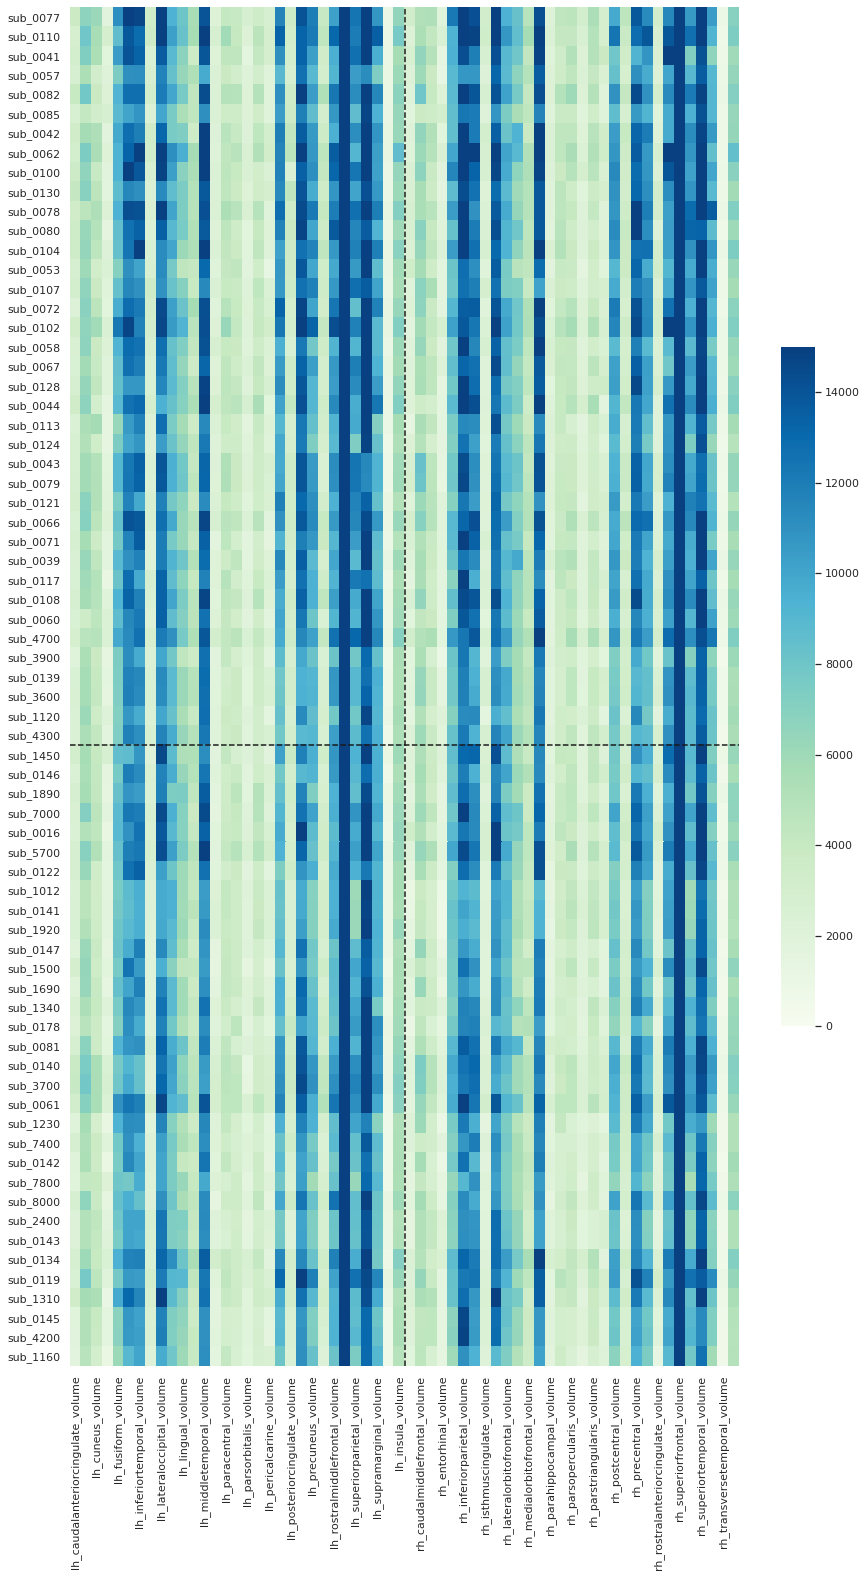

In [5]:
plot_df = all_data['DKT'].copy()
vis_list=lh_dkt_vol_col+rh_dkt_vol_col;
# sort by age
plot_df = plot_df.sort_values(['diagnosis','Vermis_VI','age'], ascending=False)
plot_df = plot_df[vis_list]
sns.set(font_scale=1)
with sns.axes_style("dark"):
    f, ax = plt.subplots(figsize=(15, 25))
    #sns.color_palette("cubehelix", as_cmap=True)
    g = sns.heatmap(plot_df,cbar_kws={"shrink": .5}, cmap="GnBu", vmin=0, vmax=15000) # , 
    plt.axhline(len(all_data['DKT'][all_data['DKT']["group"]=='ET']), ls='--', c='k')
    plt.axvline(len(lh_dkt_vol_col), ls='--', c='k')

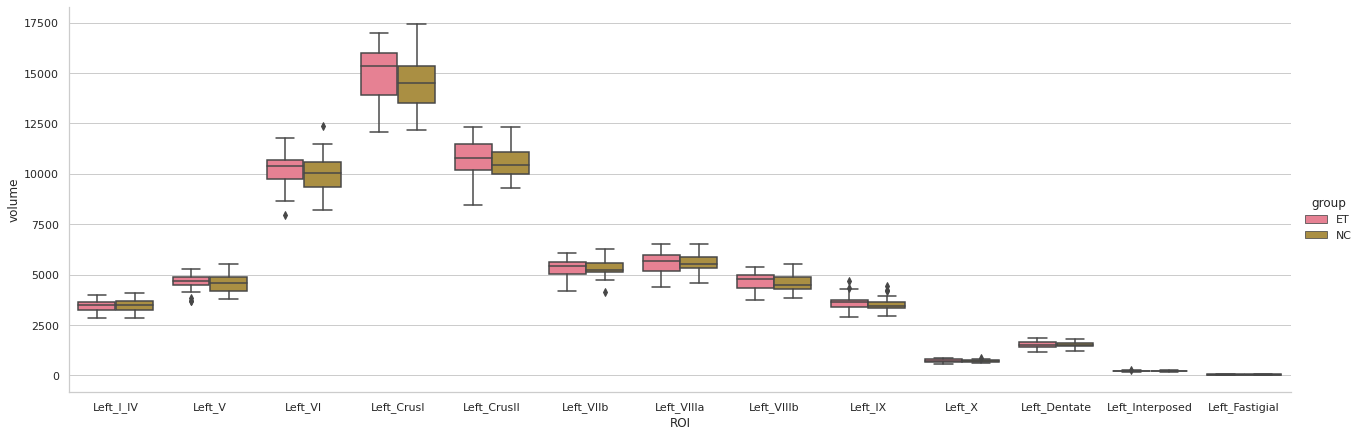

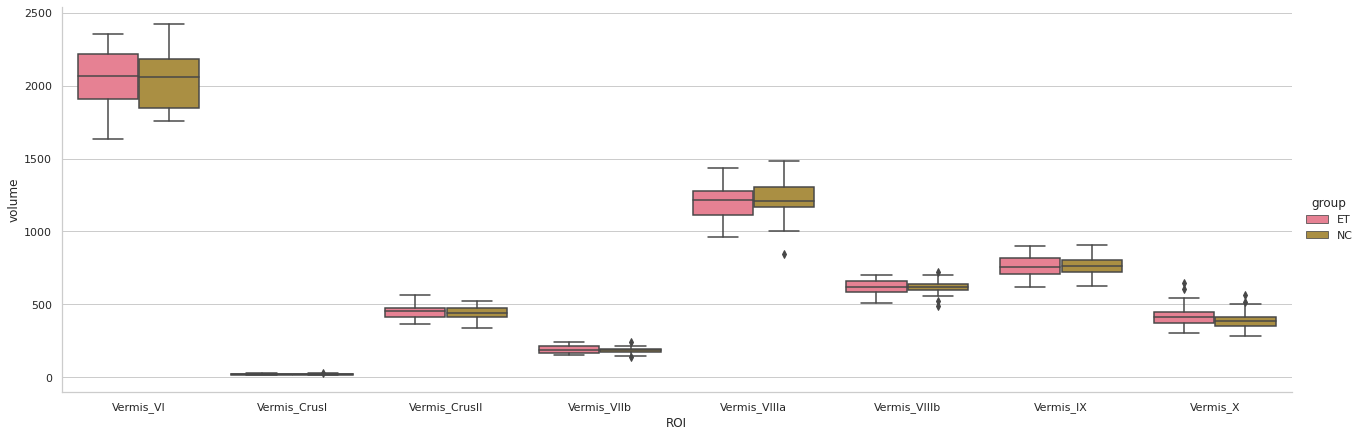

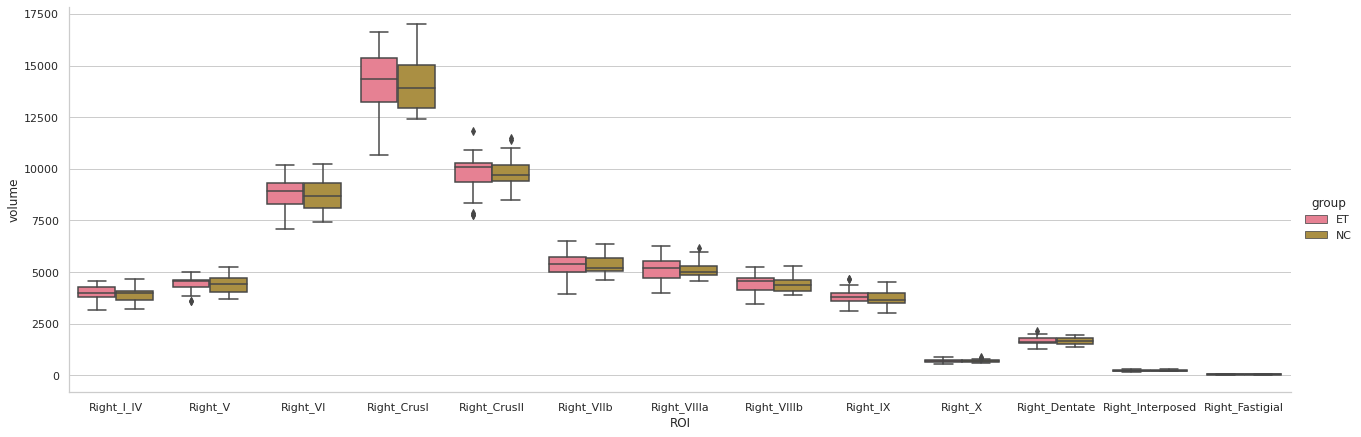

In [6]:
# SUIT lobule results vis
sns.set(font_scale=1)
vis_suit_df=all_data['Des'].copy()
vis_suit_df['participant_id']=vis_suit_df.index
palette = sns.color_palette('husl', 6)
with sns.axes_style("whitegrid"):
    plot_l_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_l_labels, 
                      var_name ='ROI', value_name ='volume')
    g = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_l_df)
    plot_v_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_v_labels, 
                      var_name ='ROI', value_name ='volume')
    g1 = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_v_df)
    plot_r_df = pd.melt(vis_suit_df, id_vars = ['participant_id','group'], value_vars = SUIT_r_labels, 
                      var_name ='ROI', value_name ='volume')
    g2 = sns.catplot(y='volume', x='ROI', hue='group', kind='box',aspect=3, height=6, palette=palette,
                    data=plot_r_df)

In [7]:
#save data
all_data['Des'].to_csv(res_file[0])
all_data['DKT'].to_csv(res_file[1])

# Some basic statistics

In [8]:
#generate the indicator variables for diagnosis and sex
#reading freesurfer results
def eqStr(x, str_y):
    if x == str_y:
        return 1
    else:
        return 0
tab_data = all_data['DKT'].copy();
tab_data['group']=tab_data['diagnosis'];
tab_data["is_PD"]     = [eqStr(x, "PD") for x in tab_data["group"]];
tab_data["is_ET"]     = [eqStr(x, "ET") for x in tab_data["group"]];
tab_data["is_NC"]     = [eqStr(x, "NC") for x in tab_data["group"]];
tab_data["is_Male"]   = [eqStr(x, "M") for x in tab_data["sex"]];
tab_data["is_Female"] = [eqStr(x, "F") for x in tab_data["sex"]];
tab_data=tab_data.rename(index=dict(zip(tab_data.index, [x.replace('-','_') for x in tab_data.index])),
                         columns=dict(zip(tab_data.columns, [x.replace('-','_') for x in tab_data.columns])),)
print(tab_data.columns)

Index(['age', 'sex', 'diagnosis', 'site', 'group', 'Left_Lateral_Ventricle',
       'Left_Inf_Lat_Vent', 'Left_Cerebellum_White_Matter',
       'Left_Cerebellum_Cortex', 'Left_Thalamus_Proper',
       ...
       'MDTB_7', 'MDTB_8', 'MDTB_9', 'MDTB_10', 'MDTB_total', 'is_PD', 'is_ET',
       'is_NC', 'is_Male', 'is_Female'],
      dtype='object', length=530)


ET 38
NC 32


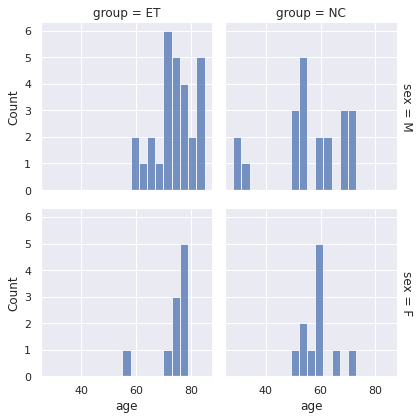

In [9]:
#plot age/sex/diagnosis distributions 2*3
for x in GROUPS:
    print(x , len(tab_data[tab_data["group"]==x]))
sns.set_theme(style="darkgrid")
sns.displot(
    tab_data, x="age", col="group", row="sex", 
    binwidth=3, height=3, facet_kws=dict(margin_titles=True))

In [10]:
#descriptive statistics of subjects
import numpy as np
import statsmodels.stats.weightstats as ws
import scipy.stats

demo_df=tab_data[["age","group","sex"]];

# 1. reporrt sex
et_m=demo_df[(demo_df['group']=='ET')&(demo_df['sex']=='M')].shape[0];
et_f=demo_df[(demo_df['group']=='ET')&(demo_df['sex']=='F')].shape[0];
nc_m=demo_df[(demo_df['group']=='NC')&(demo_df['sex']=='M')].shape[0];
nc_f=demo_df[(demo_df['group']=='NC')&(demo_df['sex']=='F')].shape[0];

print('ET Male/Female: ', et_m, '/', et_f)
print('NC Male/Female: ', nc_m, '/', nc_f)

# 2. report age mean and std
print("Group age mean:"); display(demo_df.groupby(['group']).mean())
print("Group age standard deviation:");display(demo_df.groupby(['group']).std())

# 3. chi2 tests for sex
print('chisqure test for ET and NC sex (chisq, pval):')
chisq, chi_pval = scipy.stats.chi2_contingency([[et_m, et_f], [nc_m, nc_f]])[:2]
print('\tResults are: ','chisq =%.4f, pvalue = %.4f'%(chisq, chi_pval))

# 4. t tests for age
print('Independent t test for ET and NC age (tstat, pval, df):')
t_stat,t_pval,t_df=ws.ttest_ind(demo_df[demo_df['group']=='ET']['age'], demo_df[demo_df['group']=='NC']['age'],
                                alternative='two-sided', usevar='pooled')
print('\tResults are: ','tstat =%.4f, pvalue = %.4f, df = %i'%(t_stat, t_pval, t_df))

ET Male/Female:  28 / 10
NC Male/Female:  21 / 11
Group age mean:


,age
group,
ET,73.394737
NC,56.312500


Group age standard deviation:


,age
group,
ET,6.965317
NC,11.093263


chisqure test for ET and NC sex (chisq, pval):
	Results are:  chisq =0.2220, pvalue = 0.6375
Independent t test for ET and NC age (tstat, pval, df):
	Results are:  tstat =7.8386, pvalue = 0.0000, df = 68
